In [1]:
import tensorflow as tf
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, Conv2D, Flatten, BatchNormalization, Add, MaxPooling2D, AveragePooling2D, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import sys
import random


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,concatenate
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D

import os
from scipy.io import loadmat

import random
seed = 7
np.random.seed(seed)



 


In [2]:
import math
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import LearningRateScheduler

In [3]:
from tensorflow.keras.regularizers import l2

In [4]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [5]:
# 卷积层和标准层组成的block
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1),name=None, r_s = 1e-3):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
 
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name, kernel_regularizer=l2(r_s))(x)
    x = BatchNormalization(axis=3,name=bn_name)(x)
    return x
 
# Inception Block

In [6]:
def Inception(x,nb_filter, r=1e-3):
    branch1x1 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),name=None, r_s = r)
 
    branch3x3 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),name=None,r_s = r)
    branch3x3 = Conv2d_BN(branch3x3,nb_filter,(3,3), padding='same',strides=(1,1),name=None, r_s = r)
 
    branch5x5 = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),name=None,r_s = r)
    branch5x5 = Conv2d_BN(branch5x5,nb_filter,(1,1), padding='same',strides=(1,1),name=None,r_s = r)
 
    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branchpool = Conv2d_BN(branchpool,nb_filter,(1,1),padding='same',strides=(1,1),name=None,r_s = r)
 
    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)
 
    return x

In [7]:
def build_model(r=1e-3):
    inpt = Input(shape=(60,264,1))
    #padding = 'same'，填充为(步长-1）/2,还可以用ZeroPadding2D((3,3))
    x = Conv2d_BN(inpt,64,(7,7),strides=(2,2),padding='same', r_s = r)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = Conv2d_BN(x,192,(3,3),strides=(1,1),padding='same', r_s = r)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = Inception(x,64,r = r)#256
    x = Inception(x,120,r = r)#480
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = Inception(x,128,r = r)#512
    x = Inception(x,128,r = r)
    x = Inception(x,128,r = r)
    x = Inception(x,132,r = r)#528
    x = Inception(x,208,r = r)#832
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = Inception(x,208,  r = r)
    x = Inception(x,256,  r = r)#1024
    x = AveragePooling2D(pool_size=(7,7),strides=(7,7),padding='same')(x)
    x = Dropout(0.4)(x)
    x = Dense(7,activation='relu')(x)
    x = Flatten()(x)
    x = Dense(7,activation='softmax')(x)
    model = Model(inpt,x,name='inception')
    return model

In [8]:
path = r'E:\语音大创数据\音频处理trainCqcc/'
list_root = os.listdir(path)

list_root

['bonafide',
 'ofile_time_roll',
 'ofile_time_stretch',
 'SS_1',
 'SS_2',
 'SS_4',
 'US_1',
 'VC_1',
 'VC_4']

In [7]:
# lfcc代码
Label = []
Data =[]
Label_dic = {'bonafide':0}
for path_children in list_root:
    if path_children =='ofile_time_roll' or path_children =='ofile_time_stretch' :#or path_children =='SS_4':
        continue
    if path_children in Label_dic:
        judge = Label_dic[path_children]
    else:
        judge = len(Label_dic)
        Label_dic[path_children] = judge

    path_children_ = path+path_children
    list_children = os.listdir(path_children_)
    dict_kind = {}
    
    if path_children not in dict_kind:
        dict_kind[path_children]=0
        
        
    seq = [i for i in range(len(list_children))]
    choice  = random.sample(seq,2000)
    choice.sort()
    for number,mats in enumerate(list_children):
        if number not in choice:
            continue
        dict_kind[path_children]+=1
#         if dict_kind[path_children]>2000  and path_children !='bonafide' and path_children !='ofile_time_roll' and  path_children!='ofile_time_stretch':
#             break
#         elif dict_kind[path_children]>2000:
#             break
        Label.append(judge)
        m = np.load(path_children_+'/'+mats)
        Data.append(m.T.reshape(60,264,1))

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [9]:
Label_dic

NameError: name 'Label_dic' is not defined

In [6]:
def getCqccData(list_root, size_each):
    Label = []
    Data =[]
    Label_dic = {'bonafide':0}
    for path_children in list_root:
        if path_children =='ofile_time_roll' or path_children =='ofile_time_stretch' :#or path_children =='SS_4':
            continue
        if path_children in Label_dic:
            judge = Label_dic[path_children]
        else:
            judge = len(Label_dic)
            Label_dic[path_children] = judge

        path_children_ = path+path_children
        list_children = os.listdir(path_children_)
        dict_kind = {}

        if path_children not in dict_kind:
            dict_kind[path_children]=0


        seq = [i for i in range(len(list_children))]
        choice  = random.sample(seq,size_each)
        choice.sort()
        for number,mats in enumerate(list_children):
            if number not in choice:
                continue
            dict_kind[path_children]+=1
    #         if dict_kind[path_children]>2000  and path_children !='bonafide' and path_children !='ofile_time_roll' and  path_children!='ofile_time_stretch':
    #             break
    #         elif dict_kind[path_children]>2000:
    #             break
            Label.append(judge)
            m = loadmat(path_children_+'/'+mats)
            Data.append(m['CQcc'].reshape(60,264,1))
    return Data,Label

In [74]:
trainData,trainLabel = getCqccData(list_root, 2000)

In [75]:
trainData = np.array(trainData)
trainData.shape

(14000, 60, 264, 1)

In [76]:
trainLabel = np.array(trainLabel)
trainLabel.shape

(14000,)

# 独热编码

In [77]:

y_train = to_categorical(trainLabel,num_classes= 7)
y_train[::50]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [78]:

trainData,y_train = shuffle(trainData,y_train)

## 尝试归一化 
# 归一化就是一坨屎！！

In [18]:
norm_Data = trainData / (trainData.max(axis=0) - trainData.min(axis=0))

## 调调参数

In [19]:

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 5e-4
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print("lr changed to {}".format(lrate))
    return lrate

lrate = LearningRateScheduler(step_decay)

In [79]:
def scheduler(epoch):
    # 每隔5个epoch，学习率减小为原来的1/10
    lr = K.get_value(model.optimizer.lr)
    print("LR now is {}".format(lr))
    lr = (1 - 1e-4) * lr
    if epoch % 5 == 0 and epoch != 0:
        lr = 0.6 * lr
    return lr
 
lrate = LearningRateScheduler(scheduler)

In [80]:
sgd = optimizers.SGD(lr=5e-3, decay=1e-2, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=5e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0, amsgrad=False)
model = build_model(0)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [81]:
model.summary()

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 60, 264, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_840 (Conv2D)             (None, 30, 132, 64)  3200        input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_840 (BatchN (None, 30, 132, 64)  256         conv2d_840[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_195 (MaxPooling2D (None, 15, 66, 64)   0           batch_normalization_840[0][0]    
__________________________________________________________________________________________

## 模型训练fit

In [82]:
callbacks = [
    EarlyStopping(monitor='val_accuracy',patience=20),
    ModelCheckpoint('g多分类.h5',monitor='val_accuracy',save_best_only=True,verbose=1),
    lrate
    ]

train_history = model.fit(trainData, y_train, epochs=20, batch_size=128, validation_split=0.2,callbacks=callbacks)

Train on 11200 samples, validate on 2800 samples
LR now is 0.004999999888241291
Epoch 1/20
11136/11200 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.7561
Epoch 00001: val_accuracy improved from -inf to 0.13679, saving model to g多分类.h5
11200/11200 [==============================] - 57s 5ms/sample - loss: 0.6861 - accuracy: 0.7571 - val_loss: 2.2930 - val_accuracy: 0.1368
LR now is 0.0049994997680187225
Epoch 2/20
11136/11200 [============================>.] - ETA: 0s - loss: 0.1031 - accuracy: 0.9667
Epoch 00002: val_accuracy improved from 0.13679 to 0.56179, saving model to g多分类.h5
11200/11200 [==============================] - 37s 3ms/sample - loss: 0.1036 - accuracy: 0.9664 - val_loss: 1.3891 - val_accuracy: 0.5618
LR now is 0.004998999647796154
Epoch 3/20
11136/11200 [============================>.] - ETA: 0s - loss: 0.0408 - accuracy: 0.9888
Epoch 00003: val_accuracy improved from 0.56179 to 0.92679, saving model to g多分类.h5
11200/11200 [===================

In [23]:
# define the function
def training_vis(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()

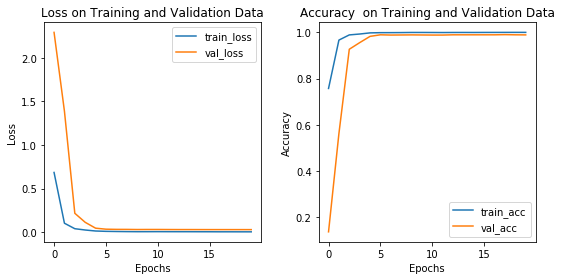

In [83]:
training_vis(train_history)

# dev开发集

In [84]:
path = r'E:\语音大创数据\音频处理devCqcc/'
list_root = os.listdir(path)

In [85]:
list_root

['bonafide', 'SS_1', 'SS_2', 'SS_4', 'US_1', 'VC_1', 'VC_4']

In [86]:
devData, devLabel =  getCqccData(list_root, 2000)

# Data = np.array(Data)

Data = (Data-Data.min())/(Data.max()-Data.min())

In [87]:
devData = np.array(devData)
devData.shape

(14000, 60, 264, 1)

In [88]:
devLabel = np.array(devLabel)
devLabel.shape

(14000,)

In [89]:
devLabel[::100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6])

In [8]:
def transport(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        if max == 0:
            test_y.append(max)
        else:
            test_y.append(1)
    return test_y

def transport1(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        test_y.append(max)
    return test_y

def label_transport(label):
    test_y = []
    for i in  label:
        if i==0:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

In [92]:

x_pre = model.predict(devData)

y_pre = transport(x_pre)
y_pre1 = transport1(x_pre)
y_true = label_transport(devLabel)

In [33]:
x_pre

array([[8.5347468e-01, 6.7348669e-06, 2.3672378e-02, ..., 2.3497664e-03,
        1.9951442e-03, 2.2513600e-02],
       [6.3040531e-01, 3.0010423e-08, 1.2149427e-03, ..., 2.3200291e-05,
        3.5751200e-01, 1.3256534e-05],
       [9.4724834e-01, 3.1335974e-06, 1.6070958e-02, ..., 3.9076657e-04,
        1.9829398e-02, 1.3136379e-03],
       ...,
       [1.2365396e-07, 3.8828361e-03, 2.2878035e-05, ..., 2.3608844e-04,
        1.6093109e-06, 9.9585634e-01],
       [1.8505190e-07, 1.3395099e-01, 3.7767948e-04, ..., 1.1093373e-03,
        7.4336526e-06, 8.6455417e-01],
       [7.3908399e-07, 5.4952462e-04, 5.7521352e-04, ..., 2.5043389e-04,
        4.9593473e-06, 9.9861896e-01]], dtype=float32)

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)   # 由原标签和预测标签生成混淆矩阵
    plt.figure(figsize=(6,6.5))
    plt.matshow(cm, cmap=plt.cm.Blues)     # 画混淆矩阵，配色风格使用cm.Blues
    plt.colorbar()    # 颜色标签
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
            # annotate主要在图形中添加注释
            # 第一个参数添加注释
            # 第二个参数是注释的内容
            # xy设置箭头尖的坐标
            # horizontalalignment水平对齐
            # verticalalignment垂直对齐
            # 其余常用参数如下：
            # xytext设置注释内容显示的起始位置
            # arrowprops 用来设置箭头
            # facecolor 设置箭头的颜色
            # headlength 箭头的头的长度
            # headwidth 箭头的宽度
            # width 箭身的宽度
    plt.ylabel('True label')  # 坐标轴标签
    plt.xlabel('Predicted label')  # 坐标轴标签
    plt.title('confusion matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()


In [10]:
def cm_plot_big(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)   # 由原标签和预测标签生成混淆矩阵
    plt.figure(figsize=(16,16.5))
    plt.matshow(cm, cmap=plt.cm.Blues)     # 画混淆矩阵，配色风格使用cm.Blues
    plt.colorbar()    # 颜色标签
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
            # annotate主要在图形中添加注释
            # 第一个参数添加注释
            # 第二个参数是注释的内容
            # xy设置箭头尖的坐标
            # horizontalalignment水平对齐
            # verticalalignment垂直对齐
            # 其余常用参数如下：
            # xytext设置注释内容显示的起始位置
            # arrowprops 用来设置箭头
            # facecolor 设置箭头的颜色
            # headlength 箭头的头的长度
            # headwidth 箭头的宽度
            # width 箭身的宽度
    plt.ylabel('True label')  # 坐标轴标签
    plt.xlabel('Predicted label')  # 坐标轴标签
    plt.title('confusion matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()

<Figure size 432x468 with 0 Axes>

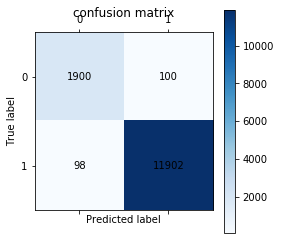

In [95]:
cm_plot(y_pre,y_true)

<Figure size 432x468 with 0 Axes>

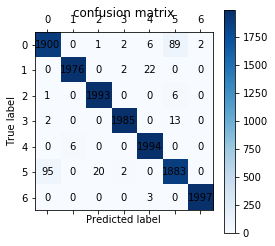

In [96]:
cm_plot(y_pre1,devLabel)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [98]:
# micro：多分类　　
# weighted：不均衡数量的类来说，计算二分类metrics的平均
# macro：计算二分类metrics的均值，为每个类给出相同权重的分值。
precision = precision_score(devLabel, y_pre1, average='weighted')
recall = recall_score(devLabel, y_pre1, average='weighted')
f1_score = f1_score(devLabel, y_pre1, average='weighted')
accuracy_score = accuracy_score(devLabel, y_pre1)
print("Precision_score:",precision)
print("Recall_score:",recall)
print("F1_score:",f1_score)
print("Accuracy_score:",accuracy_score)



# # 二分类　ＲＯＣ曲线
# # roc_curve:真正率（True Positive Rate , TPR）或灵敏度（sensitivity）
# # 横坐标：假正率（False Positive Rate , FPR）
# fpr, tpr, thresholds_keras = roc_curve(Label, y_pre)
# auc = auc(fpr, tpr)
# print("AUC : ", auc)
# plt.figure()
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.savefig("../ROC_2分类.png")
# plt.show()

Precision_score: 0.9805614133039309
Recall_score: 0.9805714285714285
F1_score: 0.9805548861997876
Accuracy_score: 0.9805714285714285


# 评估集！！！

In [9]:
path = r'E:\语音大创数据\音频处理evalCqcc/'
list_root = os.listdir(path)

list_root

['A07',
 'A08',
 'A09',
 'A10',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A16',
 'A17',
 'A18',
 'A19',
 'bonafide']

In [38]:
evalData,evalLabel = getCqccData(list_root, 2000)

In [39]:
evalData = np.array(evalData)
evalData.shape

(28000, 60, 264, 1)

# 用到这里，内存都不够了，唉太难了

In [14]:
from tensorflow.keras.models import load_model
# 加载下模型

In [15]:
 model = load_model('g多分类.h5')

In [40]:
evalLabel = np.array(evalLabel)
evalLabel.shape

(28000,)

In [12]:
def transport(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        if max == 0:
            test_y.append(max)
        else:
            test_y.append(1)
    return test_y

def transport1eval(y, yu=0.9):
    test_y = []
    for i in  y:
        if i[0]>yu:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

def label_transport(label):
    test_y = []
    for i in  label:
        if i==0:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y


In [41]:
x_pre = model.predict(evalData)

In [42]:
x_pre.shape

(28000, 7)

In [43]:
y_pre = transport(x_pre)
y_pre1 = transport1eval(x_pre, 0.884269)
y_true = label_transport(evalLabel)

In [44]:
np.array(y_pre1).shape

(28000,)

In [45]:
np.array(y_true).shape

(28000,)

In [46]:
evalLabel[::500]

array([ 1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  5,
        5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,
        9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13,
       13,  0,  0,  0,  0])

In [47]:
y_true[::500]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0]

In [25]:
def scores(pre,  true):
    # micro：多分类　　
    # weighted：不均衡数量的类来说，计算二分类metrics的平均
    # macro：计算二分类metrics的均值，为每个类给出相同权重的分值。
    precision = precision_score(pre,true, average='weighted')
    recall = recall_score(pre,true, average='weighted')
    f1_score1 = f1_score(y_pre1,y_true, average='weighted')
    accuracy_score1 = accuracy_score(y_pre1,y_true)
    print("Precision_score:",precision)
    print("Recall_score:",recall)
    print("F1_score:",f1_score1)
    print("Accuracy_score:",accuracy_score1)



# # 二分类　ＲＯＣ曲线
# # roc_curve:真正率（True Positive Rate , TPR）或灵敏度（sensitivity）
# # 横坐标：假正率（False Positive Rate , FPR）
# fpr, tpr, thresholds_keras = roc_curve(Label, y_pre1)
# auc = auc(fpr, tpr)
# print("AUC : ", auc)
# plt.figure()
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.savefig("../ROC_2分类.png")
# plt.show()

<Figure size 432x468 with 0 Axes>

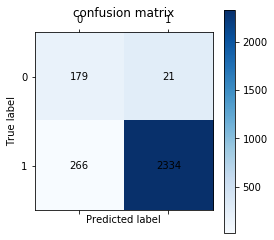

In [33]:
cm_plot(y_pre1,y_true)

# EER即 FRR = FPR的点
这里通过阈值作为x，分别作FRR和FPR曲线，两者取交点。

In [11]:
def getEER(ol, pl):
    cm = confusion_matrix(ol, pl)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    FPR = FP / (TN + FP)
    FRR = FN / (TP + FN)
    return FPR, FRR

In [27]:
testyus = np.linspace(0.5,0.95,10)
yus = list(testyus)
FPRs = []
FRRs = []
for yu in yus:
    y_pre1 = transport1eval(x_pre, yu)
    FPR, FRR = getEER(y_true, y_pre1)
    FPRs.append(FPR)
    FRRs.append(FRR)


In [28]:
print(FPRs)
print(FRRs)

[0.04, 0.05, 0.05, 0.05, 0.055, 0.06, 0.06, 0.085, 0.11, 0.12]
[0.18346153846153845, 0.1723076923076923, 0.15730769230769232, 0.14423076923076922, 0.13384615384615384, 0.12384615384615384, 0.11846153846153847, 0.10846153846153846, 0.09923076923076923, 0.08269230769230769]


Text(0.5, 1.0, ' find eer')

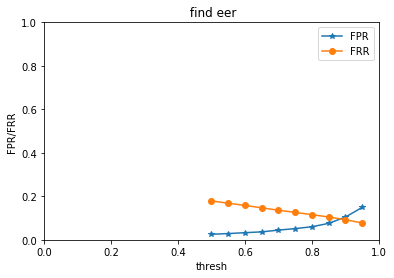

In [10]:
plt.figure()
plt.plot(yus,FPRs,marker = '*',label = 'FPR')
plt.plot(yus, FRRs, marker = 'o',label = 'FRR')
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('thresh')
plt.ylabel('FPR/FRR')
plt.title(' find eer')

# 寻找交点

In [29]:
def findX(X1, X2, T):
    #求一下两条线的交点, 默认X1递增， X2递减
    # 先找到4个点满足X11 < X21, X12 > X22 
    iT = -1
    iX = -1
    for idx, x in enumerate(X1):
        if X2[idx] > X1[idx]:
            continue
        else:
            # 找到第一个X2>X1的点
            X11 = X1[idx - 1]
            X12 = X1[idx]
            X21 = X2[idx-1]
            X22 = X2[idx]
            T1 = T[idx-1]
            T2 = T[idx]
            #由三角形相似性求
            iT = (T2-T1) * (X21-X11) / (X12 + X21 - X22 - X11) + T1
            iX = X11 + (iT - T1)/ (T2- T1) * (X12 - X11)
            break
    return iT, iX
            
            
        

In [30]:
def drawEER(yus, FPRs, FRRs):
    iT, iX = findX(FPRs, FRRs, yus)
    plt.figure()
    plt.plot(yus,FPRs,marker = '*',label = 'FPR')
    plt.plot(yus, FRRs, marker = 'o',label = 'FRR')
    plt.legend()
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('thresh')
    plt.ylabel('FPR/FRR')
    plt.title(' find eer')
    print(iT, iX)

In [15]:
# 不想加载模型了，直接测试用的代码
testyus = np.linspace(0.5,0.95,10)
yus = list(testyus)
FPRs = [0.025560444165095328,
        0.028647568287808126,
        0.03269818866149141,
        0.036523929471032744,
        0.044522396114409064,
        0.051564310544611816,
        0.059962523422860715,
        0.0756188538487623,
        0.10457759583178265,
        0.14883720930232558]
FRRs = [0.1788846153846154,
        0.16823076923076924,
        0.15815384615384614,
        0.14711538461538462,
        0.1361923076923077,
        0.12592307692307692,
        0.11576923076923076,
        0.10484615384615385,
        0.09253846153846154,
        0.07742307692307693]



0.8842696629213482 0.10213483146067415


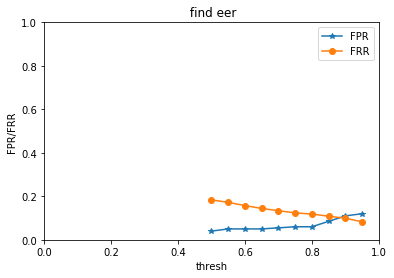

In [31]:
drawEER(yus, FPRs, FRRs)

In [ ]:
def allAboutEER(original_label, predict_label):
    

<Figure size 432x468 with 0 Axes>

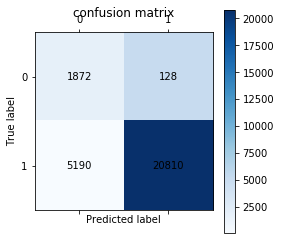

In [27]:
cm_plot(y_pre,y_true)

In [174]:
scores(y_pre,y_true)

Precision_score: 0.8159456758241759
Recall_score: 0.8179285714285714
F1_score: 0.9491679369376343
Accuracy_score: 0.9498571428571428


<Figure size 432x468 with 0 Axes>

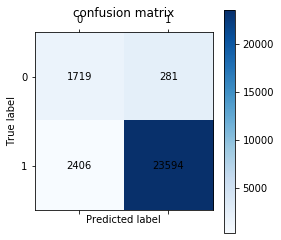

Precision_score: 0.9003957760989011
Recall_score: 0.9040357142857143
F1_score: 0.8894332003478082
Accuracy_score: 0.9040357142857143


In [34]:
y_pre1 = transport1eval(x_pre, 0.9)
cm_plot(y_pre1,y_true)
scores(y_pre1,y_true)

# 每种攻击测试

In [52]:
def transport(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        if max == 0:
            test_y.append(max)
        else:
            test_y.append(1)
    return test_y

def transport1(y):
    test_y = []
    for i in  y:
        if i[0]>0.80:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

def label_transport(label):
    test_y = []
    for i in  label:
        if i==0:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y


In [37]:
for c,path_children in  enumerate(list_root):
    Label = []
    Data =[]
    print(path_children)
    if path_children =='bonafide' or path_children =='ofile_time_roll' or  path_children=='ofile_time_stretch':
        judge = 0
    else:
#         continue
        judge = 1
        
    path_children_ = path+path_children
    list_children = os.listdir(path_children_)
    dict_kind = {}
    
    if path_children not in dict_kind:
        dict_kind[path_children]=0
        
    for mats in list_children:
        dict_kind[path_children]+=1
        if dict_kind[path_children]>1000  and path_children !='bonafide' and path_children !='ofile_time_roll' and  path_children!='ofile_time_stretch':
            break
        elif dict_kind[path_children]>1000:
            break
        Label.append(judge)
        m = np.load(path_children_+'/'+mats)
        Data.append(m.T.reshape(60,264,1))
    Data = np.array(Data)
    Label = np.array(Label)
    x_pre = model.predict(Data)
    y_pre = transport(x_pre)
    y_pre1 = transport1(x_pre)
    y_true = label_transport(Label)
    print((y_pre == Label).sum()/len(y_pre),"++++",np.array(np.array(y_pre1) == np.array(y_true)).sum()/len(y_pre1))

A07


ValueError: Cannot load file containing pickled data when allow_pickle=False

In [34]:
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def findX(X1, X2, T):
    #求一下两条线的交点, 默认X1递增， X2递减
    # 先找到4个点满足X11 < X21, X12 > X22 
    iT = -1
    iX = -1
    for idx, x in enumerate(X1):
        if X2[idx] > X1[idx]:
            continue
        else:
            # 找到第一个X2<X1的点
            X11 = X1[idx - 1]
            X12 = X1[idx]
            X21 = X2[idx-1]
            X22 = X2[idx]
            T1 = T[idx-1]
            T2 = T[idx]
            #由三角形相似性求
            iT = (T2-T1) * (X21-X11) / (X12 + X21 - X22 - X11) + T1
            iX = X11 + (iT - T1)/ (T2- T1) * (X12 - X11)
            break
    return iT, iX
            

def getEER(ol, pl):
    cm = confusion_matrix(ol, pl)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    FPR = FP / (TN + FP)
    FRR = FN / (TP + FN)
    return FPR, FRR

def transport(y):
    test_y = []
    for i in  y:
        max = np.argmax(i)
        if max == 0:
            test_y.append(max)
        else:
            test_y.append(1)
    return test_y

def transport1eval(y, yu=0.9):
    test_y = []
    for i in  y:
        if i[0]>yu:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

def label_transport(label):
    test_y = []
    for i in  label:
        if i==0:
            test_y.append(0)
        else:
            test_y.append(1)
    return test_y

def drawEER(yus, FPRs, FRRs):
    iT, iX = findX(FPRs, FRRs, yus)
    plt.figure()
    plt.plot(yus,FPRs,marker = '*',label = 'FPR')
    plt.plot(yus, FRRs, marker = 'o',label = 'FRR')
    plt.legend()
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('thresh')
    plt.ylabel('FPR/FRR')
    plt.title(' find eer')
    plt.show()
    print(iT, iX)

def allAboutEER(y_true, x_pre, threshs):
    # 这里y_true, x_pre顺序改回来了。。。
    '''
    threshs: 阈值的list
    '''
    FPRs = []
    FRRs = []
    for thresh in threshs:
        y_pre1 = transport1eval(x_pre, thresh)
        FPR, FRR = getEER(y_true, y_pre1)
        FPRs.append(FPR)
        FRRs.append(FRR)
    drawEER(threshs, FPRs, FRRs)



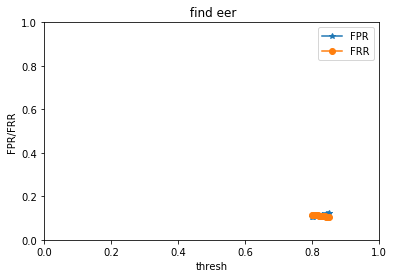

0.8229323308270676 0.111


In [52]:
testyus = np.linspace(0.8,0.85,20)
# 阈值列表
threshs = list(testyus)
allAboutEER(y_true,x_pre, threshs)

<Figure size 432x468 with 0 Axes>

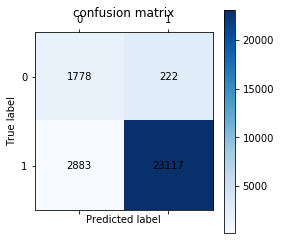

In [53]:
y_pre1 = transport1eval(x_pre, 0.8229323308270676  )
cm_plot(y_pre1,y_true)